# Tables 1, 2, and Figure 11 (Temperature as proxy)

Builds the portions of Tables 1, 2 that do not include W, Z

Requires that `run_exp_temp.py` is run

In [1]:
RPATH = '../results'
FPATH = '../figs'

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pickle as pkl

In [2]:
results = pd.read_csv(f"{RPATH}/all_res_test_TempC.csv")
results = results.drop('Unnamed: 0', axis=1)

residuals = results.drop("Lambda", axis=1).query('Environment == "Test"')
lambs = results.drop("Residual", axis=1).query('Environment == "Test"')

mse = lambda v: np.mean(v**2)

# Get RMSE by season, city
pt = pd.pivot_table(residuals, 
                    index=['Test_Season', 'City'], 
                    columns = 'Estimator', 
                    aggfunc={'Residual': mse})

pt.columns = pt.columns.droplevel(0)
pt = pt.rename(columns = {
    'OLS (All)': 'OLS (TempC)', 
    'PA (TempC)': 'OLS + Est. Bias',
    'TAR (TempC)': 'PTAR (TempC)', 
    'AR (TempC)': 'PAR (TempC)'
})
newcols = [
 'OLS',
 'OLS (TempC)',
 'OLS + Est. Bias',
 'PAR (TempC)',
 'PTAR (TempC)'
]
pt = pt[newcols].reset_index()

# Table 1

In [3]:
wins = lambda v: int(np.sum(v < 0))
loss = lambda v: int(np.sum(v > 0))

lambs_ar = lambs.query(f'Environment == "Test" & Estimator == "AR (TempC)"').groupby(
    ['City', 'Test_Season']).mean()[['Lambda']]

lambs_ar = lambs_ar.reset_index().set_index(['City', 'Test_Season'])

pt_diff = pt.copy()
for est in newcols:
    pt_diff[est] = pt[est] - pt['OLS']

pt_pos_lamb = pt.set_index(['City', 'Test_Season']).merge(lambs_ar, left_index=True, right_index=True)
pt_pos_lamb = pt_pos_lamb.query("Lambda > 0").drop("Lambda", axis=1).reset_index()

pt_diff_pos_lamb = pt_pos_lamb.copy()
for est in newcols:
    pt_diff_pos_lamb[est] = pt_pos_lamb[est] - pt_pos_lamb['OLS']

In [4]:
lt = pd.melt(pt_pos_lamb, id_vars=['Test_Season', 'City'], value_name = 'MSE', var_name = 'Estimator')

mean_result = lt.groupby('Estimator', as_index=True).agg(
    **{'Mean': pd.NamedAgg(column='MSE', aggfunc=np.mean)}
).reindex(newcols)

pt_diff_long = pd.melt(pt_diff_pos_lamb, id_vars=['Test_Season', 'City'], value_name = 'MSE', var_name='Estimator')

diff_ols = pt_diff_long.groupby('Estimator', as_index=True).agg(
    **{'min': pd.NamedAgg(column='MSE', aggfunc=np.min), 
       'max': pd.NamedAgg(column='MSE', aggfunc=np.max)}
).reindex(newcols)

win_loss_ols = pt_diff_long.groupby('Estimator', as_index=True).agg(
    **{'Win': pd.NamedAgg(column='MSE', aggfunc=wins)}
).reindex(newcols)

print(pd.concat([mean_result, win_loss_ols.astype(int), diff_ols], axis=1).to_latex(float_format="{:.3f}".format))

\begin{tabular}{lrrrr}
\toprule
{} &  Mean &  Win &    min &   max \\
Estimator       &       &      &        &       \\
\midrule
OLS             & 0.537 &    0 &  0.000 & 0.000 \\
OLS (TempC)     & 0.536 &    5 & -0.028 & 0.026 \\
OLS + Est. Bias & 0.569 &    4 & -0.072 & 0.150 \\
PAR (TempC)     & 0.531 &    6 & -0.041 & 0.006 \\
PTAR (TempC)    & 0.525 &    8 & -0.061 & 0.001 \\
\bottomrule
\end{tabular}



## Table 2

This does not include W, Z, see `results_tempC_proxies.ipynb` for those

In [5]:
pt_diff = pt.copy()
for est in newcols:
    pt_diff[est] = pt[est] - pt['OLS']

lt = pd.melt(pt, id_vars=['Test_Season', 'City'], value_name = 'MSE')

mean_result = lt.groupby('Estimator', as_index=True).agg(
    **{'Mean': pd.NamedAgg(column='MSE', aggfunc=np.mean)}
).reindex(newcols)

pt_diff_long = pd.melt(pt_diff, id_vars=['Test_Season', 'City'], value_name = 'MSE')

diff_ols = pt_diff_long.groupby('Estimator', as_index=True).agg(
    **{'Diff': pd.NamedAgg(column='MSE', aggfunc=np.mean),
       'min': pd.NamedAgg(column='MSE', aggfunc=np.min), 
       'max': pd.NamedAgg(column='MSE', aggfunc=np.max)}
).reindex(newcols)

print(pd.concat([mean_result, diff_ols], axis=1).to_latex(float_format="{:.3f}".format))

\begin{tabular}{lrrrr}
\toprule
{} &  Mean &   Diff &    min &   max \\
Estimator       &       &        &        &       \\
\midrule
OLS             & 0.457 &  0.000 &  0.000 & 0.000 \\
OLS (TempC)     & 0.455 & -0.002 & -0.028 & 0.026 \\
OLS + Est. Bias & 0.474 &  0.018 & -0.072 & 0.150 \\
PAR (TempC)     & 0.454 & -0.003 & -0.041 & 0.006 \\
PTAR (TempC)    & 0.450 & -0.007 & -0.061 & 0.002 \\
\bottomrule
\end{tabular}



In [6]:
best_city, best_season = pt_diff.sort_values(
    f"PAR (TempC)", ascending=True).head(1)[['City', 'Test_Season']].values[0]

best_case_query = f"City == {best_city} & Test_Season == {best_season}"

best_case_query

'City == 0 & Test_Season == 2'

# Figure 11

In [7]:
rmse_df = pd.read_csv(f"{RPATH}/all_rmse_test_TempC.csv")
rmse_df = rmse_df.drop('Unnamed: 0', axis=1)

In [8]:
plot_est = list(rmse_df.groupby('Estimator').mean().index.values)
plot_est

['AR (TempC)', 'Mean', 'OLS', 'OLS (All)', 'PA (TempC)', 'TAR (TempC)']

In [9]:
plot_est = [f for f in plot_est if 'Mean' not in f]

In [10]:
plot_df = rmse_df.query('Environment == "Test" & Estimator in @plot_est').copy()
plot_df['MSE'] = plot_df['RMSE'] **2

In [11]:
best_case = plot_df.query(best_case_query).copy()

In [12]:
order = [
     'OLS',
     'AR (TempC)',
     'TAR (TempC)'
]

labels = [
    'OLS',
    'PAR (TempC)',
    'PTAR (TempC)'    
]

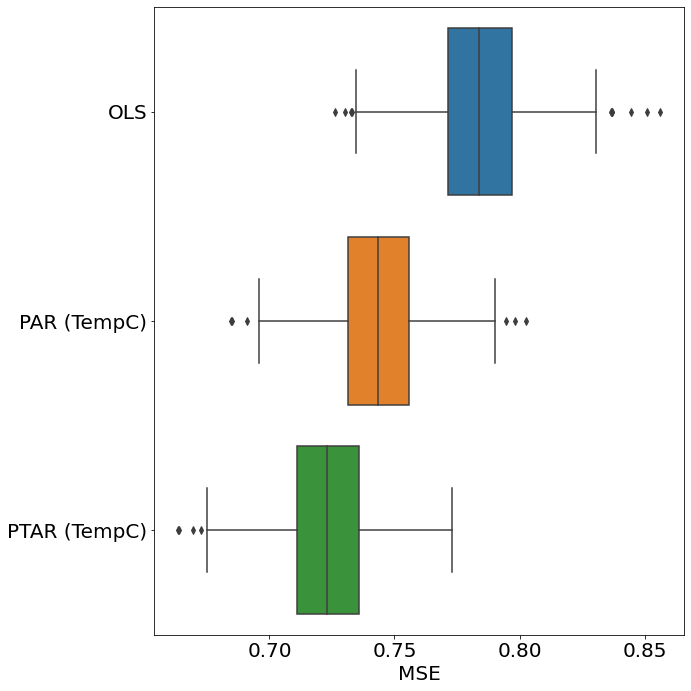

In [13]:
plt.rcParams.update({'font.size': 20})
fig, ax = plt.subplots(ncols = 1, sharey = True, figsize=(10, 10))
sns.boxplot(y = 'Estimator', x='MSE', order = order, data=best_case, ax=ax)
ax.set_ylabel(None)
ax.set_yticklabels(labels)
plt.tight_layout()
plt.savefig(f"{FPATH}/best_case_performance_TempC.pdf")